# Comparing our samplers on various energy functions

In this notebook we explore the behaviour of our different sampling methods when applied to a variety of standard energy functions from the literature. 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K
import pymc3

from pysgmcmc.samplers.sghmc import SGHMCSampler
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.samplers.sgld import SGLDSampler
from pysgmcmc.samplers.sghmchd import SGHMCHDSampler

from pysgmcmc.samplers.energy_functions import (
    Banana, Gmm1, Gmm2, Gmm3, MoGL2HMC, 
    to_negative_log_likelihood
)
from pysgmcmc.diagnostics import PYSGMCMCTrace


ENERGY_FUNCTIONS = {
    "banana": (
        Banana(),
        lambda: [K.random_normal_variable(shape=(1,), mean=0., scale=1., name="x"), 
                 K.random_normal_variable(shape=(1,), mean=0., scale=1., name="y")],
        lambda samples: plt.scatter(samples[:, 0], samples[:, 1]),
    ),
    "gmm1": (
        Gmm1(),
        lambda: [K.variable(K.random_normal((1,)), name="x")],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "gmm2": (
        Gmm2(),
        lambda: [K.variable(K.random_normal((1,)), name="x")],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "gmm3": (
        Gmm3(),
        lambda: [K.variable(K.random_normal((1,)), name="x")],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
    "mog-l2hmc": (
        MoGL2HMC(),
        lambda: [K.variable(K.random_normal((1,)), name="x")],
        lambda samples: sns.distplot(samples, kde=True, hist=False, norm_hist=True)
    ),
}

SAMPLERS = (
    SGHMCHDSampler, SGHMCSampler, SGLDSampler, #RelativisticSGHMCSampler
)

METRICS = {
    # minimum ess across all dimensions
    "ess": lambda trace: min(pymc3.diagnostics.effective_n(trace).values()),
    #"gelman_rubin": pymc3.diagnostics.gelman_rubin,
    #"geweke": pymc3.diagnostics.geweke,
    # XXX: Add autocorrelation
}


def sample(sampler, n_samples=10**5, burn_in_steps=0, keep_every=1):
    _ = list(islice(sampler, burn_in_steps))
    return np.asarray([sample for _, sample in islice(sampler, keep_every, n_samples * keep_every + keep_every)])

def evaluate_samplers(function_name, n_chains=2, samples_per_chain=10**4, burn_in_steps=0, keep_every=1):
    def chains(sampler, energy_function, initial_guess):
        traces = []
        
        def chain(chain_id):
            chain, snapshots = [], []
            initial_sample = initial_guess()
            sampler_object = sampler(loss=to_negative_log_likelihood(energy_function)(initial_sample),
                                     params=initial_sample, lr=0.01, burn_in_steps=3000)
            chain, snapshots = [], []
            
            for _ in range(samples_per_chain):
                _, sample = next(sampler_object)
                chain.append(sample)
                snapshots.append(PYSGMCMCTrace(chain_id=chain_id, samples=chain))
            return snapshots
        
        return zip(*[chain(chain_id) for chain_id in range(n_chains)])

    energy_function, initial_guess, plot_samples = ENERGY_FUNCTIONS[function_name]

    from collections import defaultdict
    
    metric_results = {
        metric_name: defaultdict(dict)
        for metric_name in METRICS 
    }
    
    for sampler in SAMPLERS:
        sampler_chains = chains(sampler, energy_function, initial_guess)
        
        for timestep, chain_tuple in enumerate(sampler_chains):
            print(chain_tuple)
            for metric_name, metric_dict in metric_results.items():
                metric_function = METRICS[metric_name]
                metric_dict[sampler.__name__][timestep] = metric_function(
                    pymc3.backends.base.MultiTrace(chain_tuple)
                )
    return metric_results
        

def plot_samplers(function_name):
    energy_function, initial_guess, plot_samples = ENERGY_FUNCTIONS[function_name]

    for sampler in SAMPLERS:
        initial_sample = initial_guess()
        loss = to_negative_log_likelihood(energy_function)(initial_sample)
        samples = np.squeeze(sample(sampler(loss=loss, params=initial_sample, lr=0.01, burn_in_steps=3000)))
        energy_function.plot()
        plot_samples(samples)
        plt.title(sampler.__name__)
        plt.show(),

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Banana
Below we give sample based approximation of a banana shaped function.

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


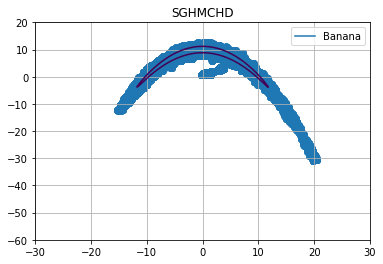

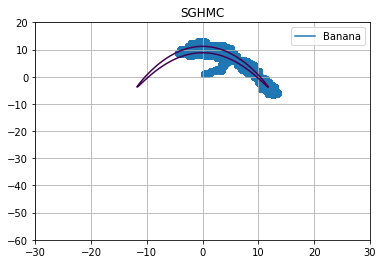

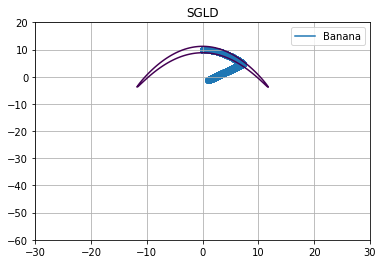

In [ ]:
plot_samplers("banana")

In [14]:
evaluate_samplers("banana", samples_per_chain=100)

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512aa71e10>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a38af28>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a9deb00>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a22cc18>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512b61edd8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a327978>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f513347b780>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a2085f8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a866c50>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a18b940>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a866cc0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a18b898>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a866f60>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a18bb38>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a866ef0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a87bef0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a49e8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a87bd30>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4a90>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a87bf98>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4b00>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a87bcc0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4ba8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a8020b8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4c88>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a8021d0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4d30>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a802080>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1a4dd8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a802240>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a13d978>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129e8df60>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a023780>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129d89e10>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129fbbc50>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129dab7b8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f4a780>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129d1a668>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f605f8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f6d208>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f60400>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f6d0f0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f606a0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f6d0b8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f60748>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f772e8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc4eb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f77470>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc9128>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f774e0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc9240>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f77400>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc9208>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f776a0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc92e8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f77668>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc9390>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f777f0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129cc9438>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129f77860>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129c31da0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129a573c8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512a1ac5f8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129a3a9e8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129c6ac88>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b05fd0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129babb70>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129a0a3c8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129bca208>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129a0a710>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b44860>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129982358>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b447f0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129982208>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b44908>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e4e0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b53908>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e518>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b53dd8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e470>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512998f2b0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e748>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512998f208>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e6a0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512998f390>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e7b8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512998f2e8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e860>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512998f358>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129b5e9e8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

{'ess': defaultdict(dict,
             {'SGHMC': {0: array([1.]),
               1: array([1.]),
               2: array([1.]),
               3: array([1.]),
               4: array([1.]),
               5: array([1.]),
               6: array([1.]),
               7: array([1.]),
               8: array([1.]),
               9: array([1.]),
               10: array([1.]),
               11: array([1.]),
               12: array([1.]),
               13: array([1.]),
               14: array([1.]),
               15: array([1.]),
               16: array([1.]),
               17: array([1.]),
               18: array([1.]),
               19: array([1.]),
               20: array([1.]),
               21: array([1.]),
               22: array([1.]),
               23: array([1.]),
               24: array([1.]),
               25: array([1.]),
               26: array([1.]),
               27: array([1.]),
               28: array([1.]),
               29: array([1.]),
               

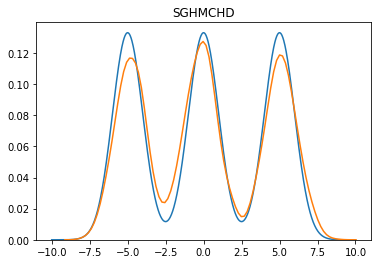

In [ ]:
plot_samplers("gmm1")

In [15]:
evaluate_samplers("gmm1", samples_per_chain=100)

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129395978>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128e9fdd8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512934f5c0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128cbaef0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5129373898>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128c4cdd8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51295a77b8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128eb6e48>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51295fcc18>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bcfeb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292d2358>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bcfef0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292d2208>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128e88908>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292d2160>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5080>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebcf8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5208>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebd30>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5048>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebf28>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e50f0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebeb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e51d0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebb38>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5198>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebfd0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5128>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128bebe80>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51292e5400>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51287af4a8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128adb748>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128619f60>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51288d09e8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51285e09b0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128904f60>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128565dd8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128209f60>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128565a90>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128209ef0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128575860>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128219c50>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51285759e8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128219eb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128575a58>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d7b8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822d908>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d320>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822dd68>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d6d8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822dc50>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d908>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822ddd8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d978>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822dc88>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d470>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822deb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858da20>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512822df28>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512858d9b0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512832add8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512806b860>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512855d4a8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123f8f5c0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282f29b0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123f8feb8>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128342eb8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fc6da0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128342780>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512828e438>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51283429b0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fdf588>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5128342860>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fdfb38>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f512830c5f8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a2198>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fabc18>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a2400>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fabf60>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a2438>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fabda0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a24a8>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fabef0>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a25c0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fb1048>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a2630>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fb1278>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a26a0>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f5123fb1198>)
(<pysgmcmc.diagnostics.PYSGMCMCTrace object at 0x7f51282a2668>, <pysgmcmc.diagnostics.PYSGMCMCTrace object at 0

{'ess': defaultdict(dict,
             {'SGHMC': {0: array([1.]),
               1: array([1.]),
               2: array([1.]),
               3: array([1.]),
               4: array([1.]),
               5: array([1.]),
               6: array([1.]),
               7: array([1.]),
               8: array([1.]),
               9: array([1.]),
               10: array([1.]),
               11: array([1.]),
               12: array([1.]),
               13: array([1.]),
               14: array([1.]),
               15: array([1.]),
               16: array([1.]),
               17: array([1.]),
               18: array([1.]),
               19: array([1.]),
               20: array([1.]),
               21: array([1.]),
               22: array([1.]),
               23: array([1.]),
               24: array([1.]),
               25: array([1.]),
               26: array([1.]),
               27: array([1.]),
               28: array([1.]),
               29: array([1.]),
               

Next, we decrease the variances of the component gaussians to `(1.0 / 0.5, 0.5, 1.0 / 0.5)` while keeping all gaussian means the same.

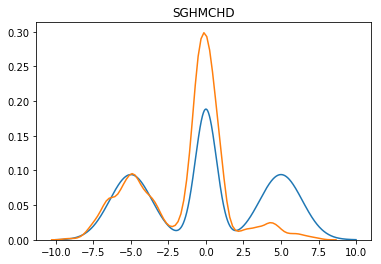

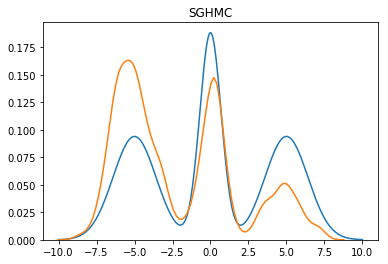

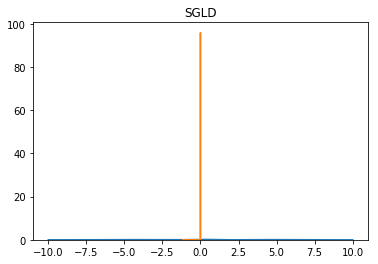

In [3]:
plot_samplers("gmm2")

In [ ]:
evaluate_samplers("gmm2", samples_per_chain=100)

Next, we decrease the variances of the component gaussians to `(1.0 / 0.3, 0.3, 1.0 / 0.3)` while keeping all means the same.

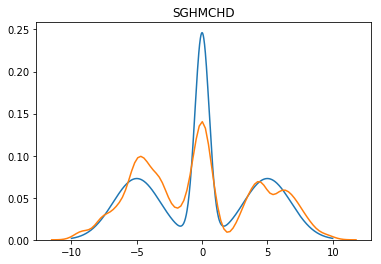

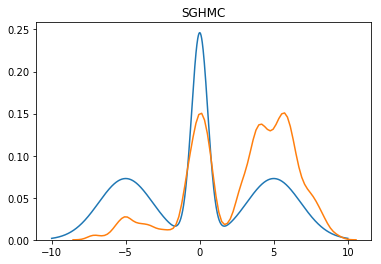

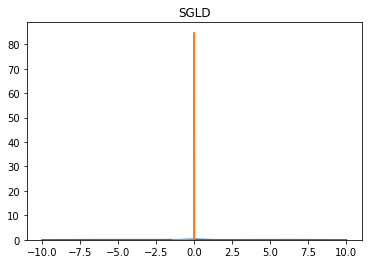

In [4]:
plot_samplers("gmm3")

In [ ]:
evaluate_samplers("gmm3", samples_per_chain=100)

Next, we try an extra-hard mixture of gaussians, introduced in the L2HMC paper. 
Variance of both gaussians is `0.1` and the two means are distance `4` (`12` standard deviations) apart. This makes it highly improbable for  hmc methods to mix between modes.

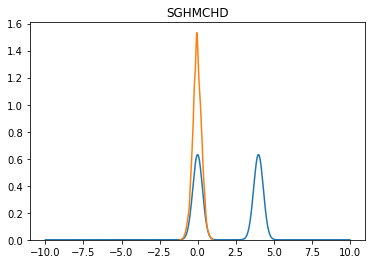

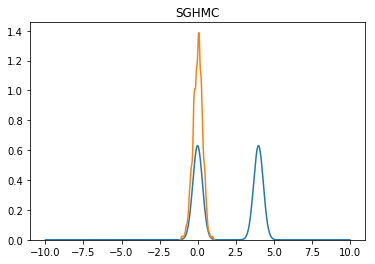

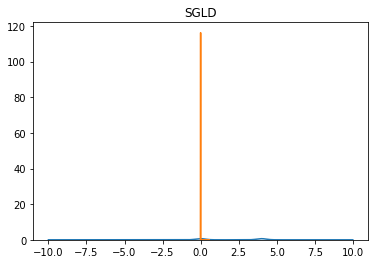

In [5]:
plot_samplers("mog-l2hmc")

In [30]:
evaluate_samplers("mog-l2hmc", samples_per_chain=100)

{'SGHMC': {'ess': {'0': 2.0},
  'gelman_rubin': {'0': 1.493066158784644},
  'geweke': {0: {'0': array([[ 0.00000000e+00, -5.43342972e+00],
           [ 2.00000000e+00, -5.35020590e+00],
           [ 4.00000000e+00, -5.25682974e+00],
           [ 6.00000000e+00, -5.14587069e+00],
           [ 8.00000000e+00, -5.06034851e+00],
           [ 1.00000000e+01, -5.05669975e+00],
           [ 1.20000000e+01, -5.02168512e+00],
           [ 1.40000000e+01, -4.99183035e+00],
           [ 1.60000000e+01, -4.94467783e+00],
           [ 1.80000000e+01, -4.84723234e+00],
           [ 2.00000000e+01, -4.83059549e+00],
           [ 2.20000000e+01, -4.50276327e+00],
           [ 2.40000000e+01, -4.14741564e+00],
           [ 2.60000000e+01, -3.78446269e+00],
           [ 2.80000000e+01, -3.41520381e+00],
           [ 3.00000000e+01, -3.19431639e+00],
           [ 3.20000000e+01, -2.76298451e+00],
           [ 3.40000000e+01, -2.27855301e+00],
           [ 3.60000000e+01, -1.67702663e+00],
           [ 3.

Next, we test our samplers on energy functions introduced in the L2HMC paper. We start with their rough well function.